### PREPROCESSING DATA

Import library

In [268]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator


In [269]:
data = pd.read_csv('tracks_features.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                100000 non-null  object 
 1   name              100000 non-null  object 
 2   album             100000 non-null  object 
 3   album_id          100000 non-null  object 
 4   artists           100000 non-null  object 
 5   artist_ids        100000 non-null  object 
 6   track_number      100000 non-null  int64  
 7   disc_number       100000 non-null  int64  
 8   explicit          100000 non-null  bool   
 9   danceability      100000 non-null  float64
 10  energy            100000 non-null  float64
 11  key               100000 non-null  int64  
 12  loudness          100000 non-null  float64
 13  mode              100000 non-null  int64  
 14  speechiness       100000 non-null  float64
 15  acousticness      100000 non-null  float64
 16  instrumentalness  100

array([[<AxesSubplot: title={'center': 'track_number'}>,
        <AxesSubplot: title={'center': 'disc_number'}>,
        <AxesSubplot: title={'center': 'danceability'}>,
        <AxesSubplot: title={'center': 'energy'}>],
       [<AxesSubplot: title={'center': 'key'}>,
        <AxesSubplot: title={'center': 'loudness'}>,
        <AxesSubplot: title={'center': 'mode'}>,
        <AxesSubplot: title={'center': 'speechiness'}>],
       [<AxesSubplot: title={'center': 'acousticness'}>,
        <AxesSubplot: title={'center': 'instrumentalness'}>,
        <AxesSubplot: title={'center': 'liveness'}>,
        <AxesSubplot: title={'center': 'valence'}>],
       [<AxesSubplot: title={'center': 'tempo'}>,
        <AxesSubplot: title={'center': 'duration_ms'}>,
        <AxesSubplot: title={'center': 'time_signature'}>,
        <AxesSubplot: title={'center': 'year'}>]], dtype=object)

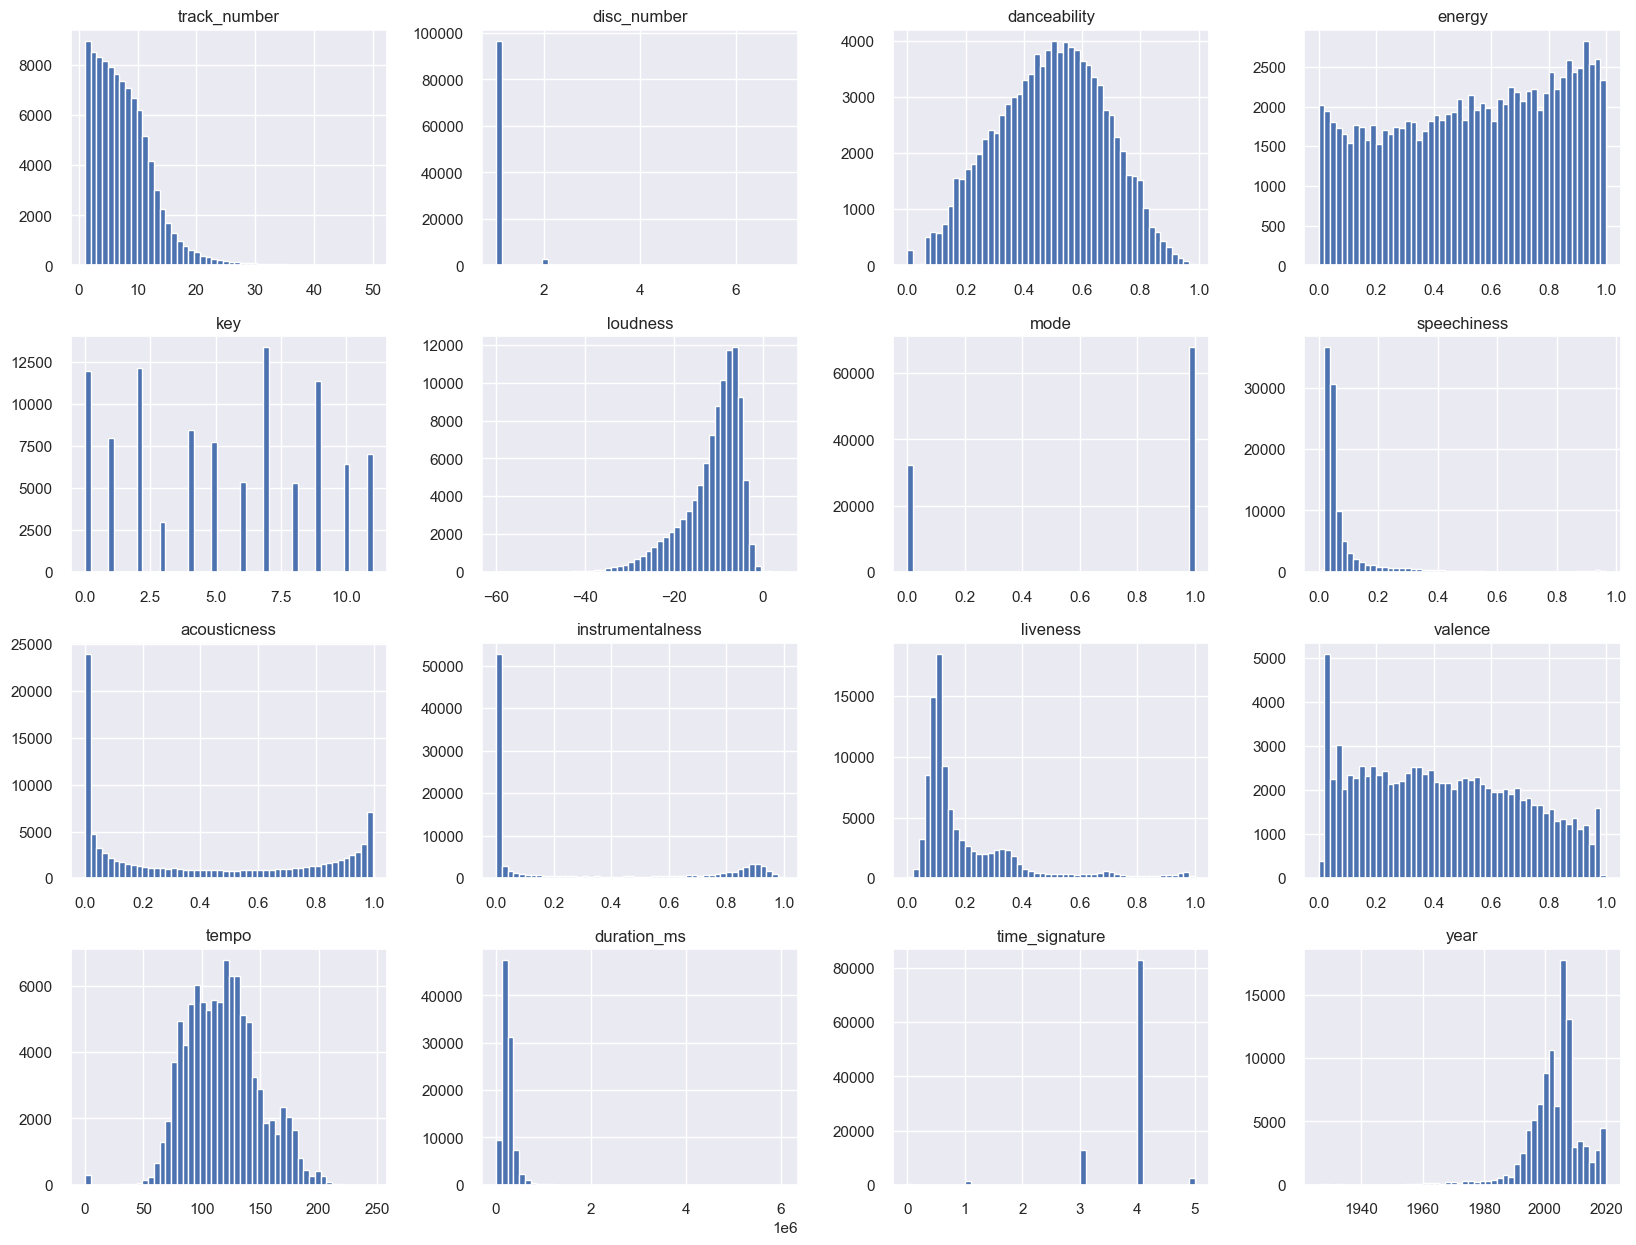

In [270]:
data.hist(bins=50, figsize=(20,15))

Based on the histograms above, we select "danceability" and "tempo" features because their histograms have normal-distribution shapes.

In [271]:
song_data = pd.read_csv('tracks_features.csv',skiprows=range(1, 1001),nrows=1000)
song_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1000 non-null   object 
 1   name              1000 non-null   object 
 2   album             1000 non-null   object 
 3   album_id          1000 non-null   object 
 4   artists           1000 non-null   object 
 5   artist_ids        1000 non-null   object 
 6   track_number      1000 non-null   int64  
 7   disc_number       1000 non-null   int64  
 8   explicit          1000 non-null   bool   
 9   danceability      1000 non-null   float64
 10  energy            1000 non-null   float64
 11  key               1000 non-null   int64  
 12  loudness          1000 non-null   float64
 13  mode              1000 non-null   int64  
 14  speechiness       1000 non-null   float64
 15  acousticness      1000 non-null   float64
 16  instrumentalness  1000 non-null   float64
 

Normalization

In [272]:
columns_to_scale = ['danceability', 'tempo']
scaler = MinMaxScaler()
scaler.fit(song_data[columns_to_scale])
data_scaled = song_data.copy()
data_scaled[columns_to_scale] = scaler.transform(song_data[columns_to_scale])


In [273]:
X = data_scaled.iloc[:, [9,19]].values
X

array([[0.27849462, 0.42212533],
       [0.44408602, 0.6408145 ],
       [0.54516129, 0.42684358],
       ...,
       [0.71827957, 0.645726  ],
       [0.78172043, 0.63629893],
       [0.51505376, 0.77778982]])

remove outlier

In [274]:
# Calculate Z-scores for each attribute
z_scores = np.abs((X - X.mean()) / X.std())

# Define a threshold for outlier detection (e.g., Z-score > 3)
threshold = 3

# Create a mask to identify outliers
outlier_mask = z_scores > threshold

# Remove outliers from the dataset
data_cleaned = X[~outlier_mask.any(axis=1)]

# Print the original and cleaned dataset sizes
print("Original Dataset Size:", X.shape)
print("Cleaned Dataset Size:", data_cleaned.shape)

X = data_cleaned.copy()

Original Dataset Size: (1000, 2)
Cleaned Dataset Size: (997, 2)


X: normalized dataset in danceability and tempo

### I. K-MEANS CLUSTERING

Elbow method to find the optimal number of clusters

In [275]:
wcss = []
iter = []
db_score = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, n_init="auto", init = 'k-means++',random_state=41)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    iter.append(kmeans.n_iter_)

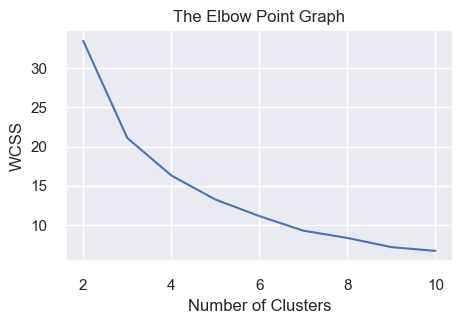

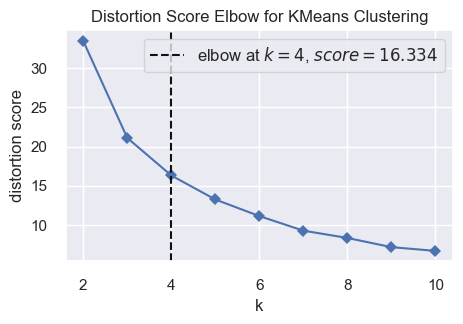

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [276]:
# plot an elbow graph

sns.set()
plt.plot(range(2,11), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,11), timings=False)
# Fit data to visualizer
visualizer.fit(X)
# Finalize and render figure
visualizer.show()

In [277]:
kmeans = KMeans(n_clusters = 5, n_init="auto", init = 'k-means++',random_state=41)

#return a label for each data point based on their cluster
Y = kmeans.fit_predict(X)

print(Y)

[4 3 0 2 4 2 0 4 4 3 3 3 1 1 3 1 1 2 0 0 3 3 4 4 2 2 2 2 1 0 4 2 4 4 0 4 4
 2 4 4 4 3 4 0 2 2 2 2 2 2 4 0 3 0 4 4 4 2 4 4 4 3 3 4 2 4 3 4 0 1 1 1 3 1
 1 1 1 2 3 0 0 0 0 0 2 1 1 2 1 3 3 2 2 0 2 2 3 3 1 3 2 3 2 2 3 3 0 0 2 0 4
 0 1 3 2 2 0 3 2 3 4 3 0 1 0 1 0 3 1 3 1 0 1 3 3 1 3 4 2 2 1 1 2 2 3 3 0 3
 3 1 0 3 3 0 1 1 2 3 1 1 0 1 3 0 1 1 3 1 0 1 1 3 4 3 3 4 3 0 3 3 3 1 0 0 3
 3 2 0 3 3 3 4 1 0 1 0 2 3 3 3 2 3 4 3 3 2 3 4 0 0 2 2 2 2 3 3 3 2 1 0 3 2
 2 0 2 4 0 3 3 3 3 1 1 1 2 1 1 3 3 3 2 3 2 3 2 2 2 2 3 3 3 3 1 3 1 3 1 2 3
 1 4 4 4 2 4 3 4 4 4 4 4 4 4 4 0 3 3 1 0 4 1 0 4 4 3 4 2 3 2 4 1 0 1 1 1 1
 1 1 1 1 1 1 1 4 2 4 2 2 0 4 0 2 0 4 2 4 4 1 1 2 2 0 3 3 1 2 0 1 2 0 3 0 0
 0 2 3 1 1 1 0 0 1 3 2 3 4 4 2 3 4 2 0 2 2 2 2 4 4 2 0 0 0 2 4 0 2 2 2 2 2
 3 0 2 3 4 3 0 4 2 3 1 2 3 1 1 0 2 3 3 1 1 0 3 3 3 0 1 1 3 2 1 2 1 2 4 0 1
 2 1 1 3 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 3 3 1 1 1 3 1 3 0 3 1 0 1 3 1 1 2 1
 1 3 3 1 1 1 1 3 0 0 1 3 1 1 3 1 1 1 1 1 1 1 0 1 1 1 2 3 0 0 4 0 2 4 3 2 4
 2 4 4 4 4 4 4 4 4 2 0 1 

Visualizing all the clusters

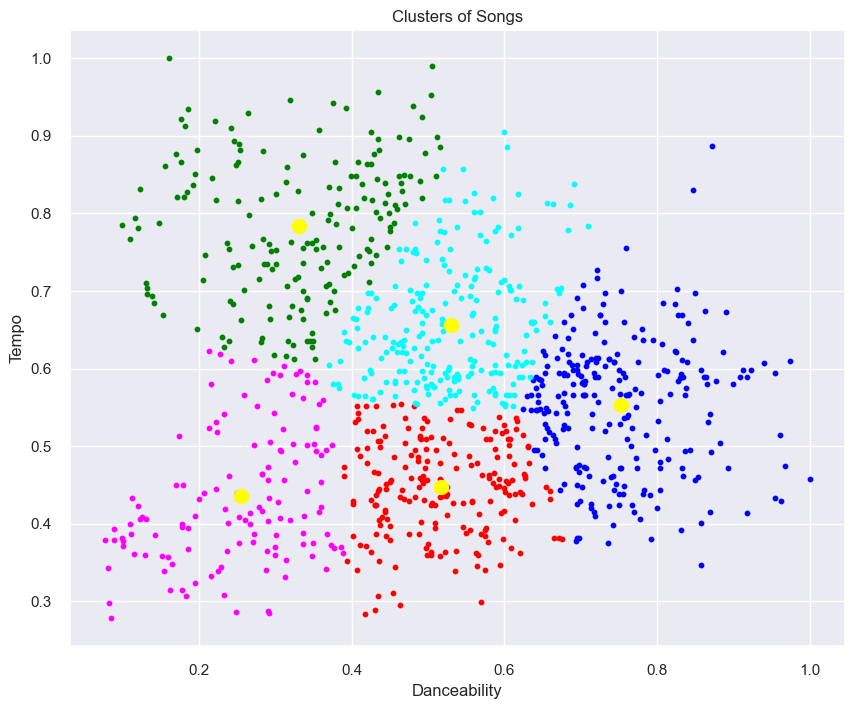

In [278]:
# plotting all the clusters and their centroids
plt.figure(figsize=(10, 8))
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], s = 10, c = 'blue', label = 'Cluster 2')
plt.scatter(X[Y == 2, 0], X[Y == 2, 1], s = 10, c = 'green', label = 'Cluster 3')
plt.scatter(X[Y == 3, 0], X[Y == 3, 1], s = 10, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[Y == 4, 0], X[Y == 4, 1], s = 10, c = 'magenta', label = 'Cluster 5')
plt.scatter(X[Y == 5, 0], X[Y == 5, 1], s = 10, c = 'orange', label = 'Cluster 6')
# plt.scatter(X[:, 0], X[:,1], c = Y, cmap= "plasma") # plotting the clusters
# plt.xlabel("Dancability") # X-axis label
# plt.ylabel("Energy") # Y-axis label
# plt.show() # showing the plot

#plotting centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters of Songs')
plt.xlabel('Danceability')
plt.ylabel('Tempo')
plt.show()


Davies Bouldin Index

In [279]:
labels = kmeans.labels_
davies_bouldin_score(X, Y)

0.8743074543297545

Silhouette

In [280]:
silhouette_score(X, Y)

0.35657077290167183

In [281]:
X

array([[0.27849462, 0.42212533],
       [0.44408602, 0.6408145 ],
       [0.54516129, 0.42684358],
       ...,
       [0.71827957, 0.645726  ],
       [0.78172043, 0.63629893],
       [0.51505376, 0.77778982]])

### II. HIERARCHICAL CLUSTERING

Dendrogram to select  the number of clusters

Text(0, 0.5, 'Euclidean distances')

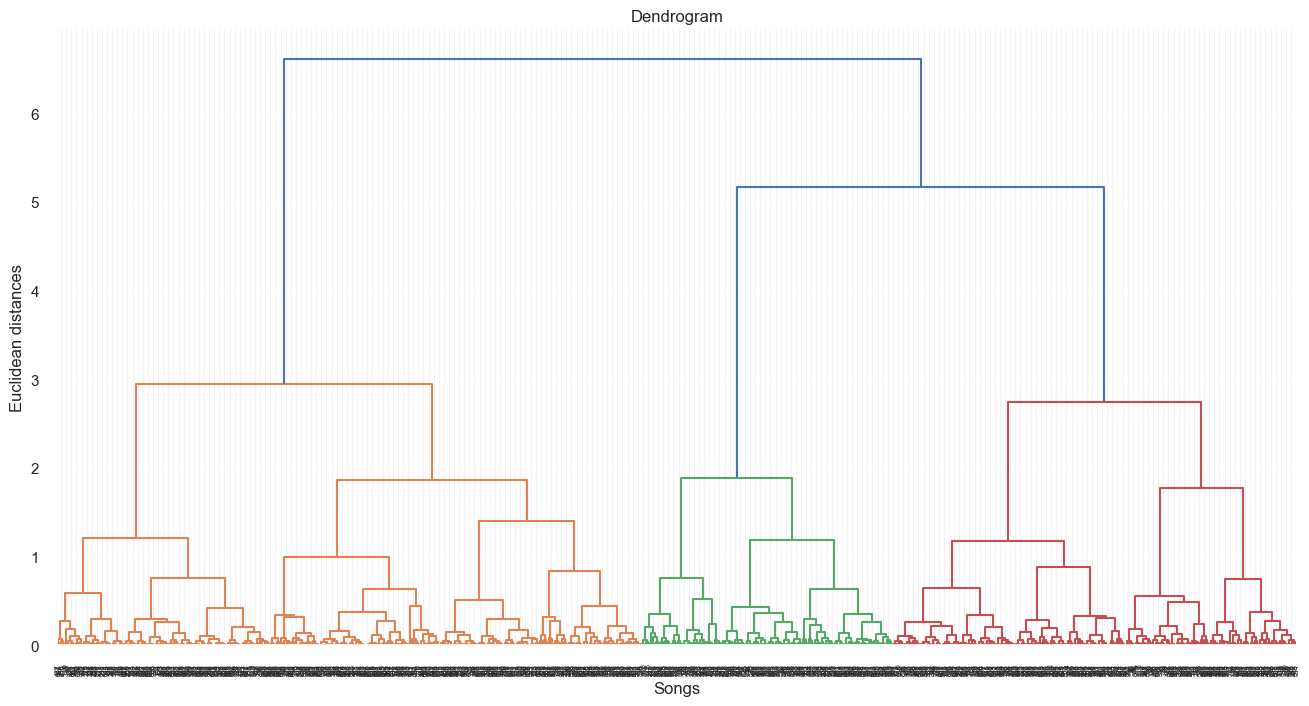

In [282]:
# graph size
plt.figure(1, figsize = (16 ,8))
# creating the dendrogram
dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
# ploting graphabs
plt.title('Dendrogram')
plt.xlabel('Songs')
plt.ylabel('Euclidean distances')

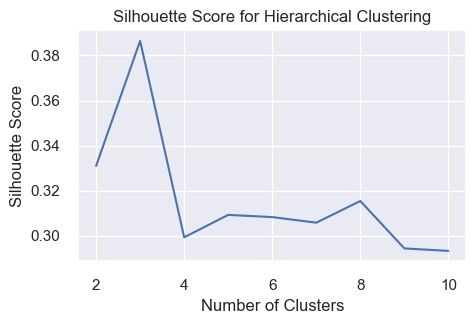

Optimal number of clusters: 3


In [283]:

# Range of cluster numbers to try
min_clusters = 2
max_clusters = 10

# Store silhouette scores
silhouette_scores = []

for n_clusters in range(min_clusters, max_clusters+1):
    # Perform hierarchical clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    clustering.fit(X)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, clustering.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Hierarchical Clustering')
plt.show()

# Find the optimal number of clusters
optimal_num_clusters = np.argmax(silhouette_scores) + min_clusters
print("Optimal number of clusters:", optimal_num_clusters)

Apply hierchical clustering

In [284]:
cluster = AgglomerativeClustering(n_clusters = optimal_num_clusters, metric = 'euclidean', linkage = 'ward')
Y_hierchical=cluster.fit_predict(X)

Visualize

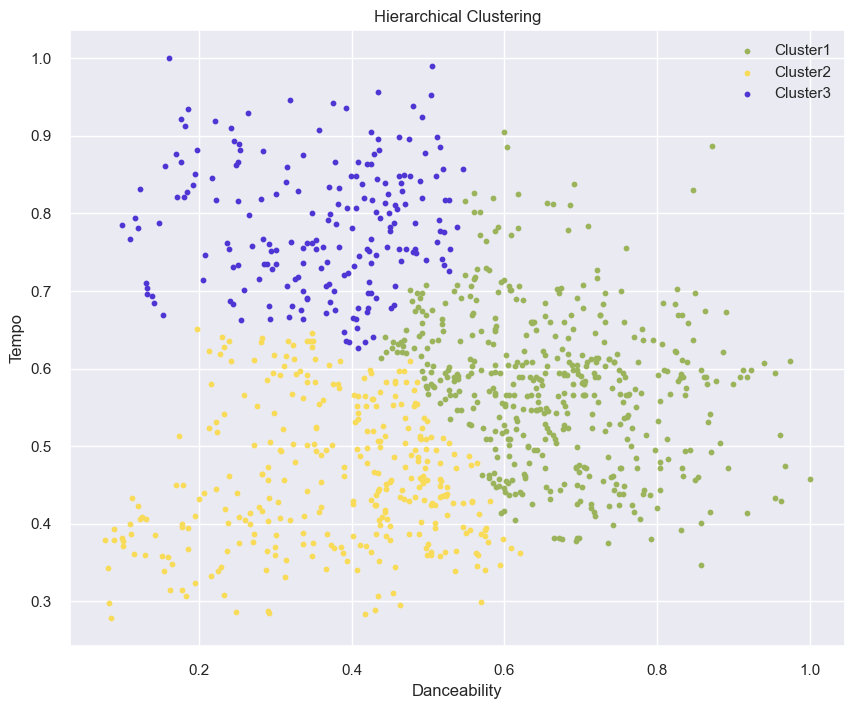

In [285]:
import random
plt.figure(figsize=(10, 8))  

# Generate random colors
colors = ['#' + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in range(optimal_num_clusters)]

for cluster_num in range(optimal_num_clusters):
    plt.scatter(X[Y_hierchical == cluster_num, 0], X[Y_hierchical == cluster_num, 1], s=10, c=colors[cluster_num], label=f'Cluster{cluster_num+1}')

plt.title('Hierarchical Clustering')
plt.xlabel('Danceability')
plt.ylabel('Tempo')
plt.legend()
plt.show()

Score

In [286]:
davies_bouldin_avg = davies_bouldin_score(X, Y_hierchical)

print("The average davies_bouldin_score is :", davies_bouldin_avg)

silhouette_avg = silhouette_score(X, Y_hierchical)

print("The average silhouette_score is :", silhouette_avg)

The average davies_bouldin_score is : 0.8651008784376396
The average silhouette_score is : 0.386421322651321


### III. DENSITY-BASED SCAN CLUSTERING

Calculate the parameters

In [287]:
no_neighbors = 4 # setting the number of neighbors
neighb = NearestNeighbors(n_neighbors=no_neighbors) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(X) # fitting the data to the object
distances,indices=nbrs.kneighbors(X) # finding the nearest neighbours

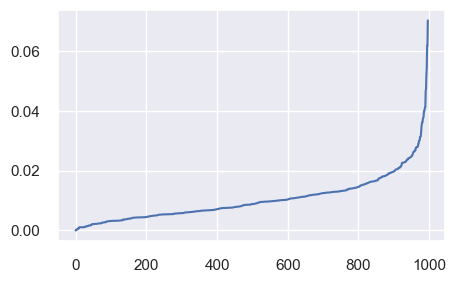

In [288]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

In [289]:
kneedle = KneeLocator(x = range(1, len(distances)+1), y = distances, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
kneedle.knee_y

0.061896954732636976

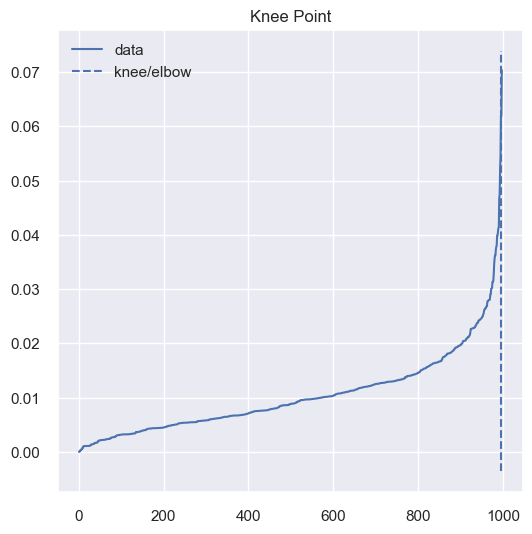

In [290]:
kneedle.plot_knee()
plt.show()

minPoints = 
Eps = 

Implementing DBScan

In [299]:
# cluster the data into five clusters
dbscan = DBSCAN(eps = 0.0618, min_samples = 4).fit(X) # fitting the model
Y = dbscan.fit_predict(X) # getting the predicted values
labels = dbscan.labels_ # getting the labels
set(labels) # getting the unique labels

{-1, 0}

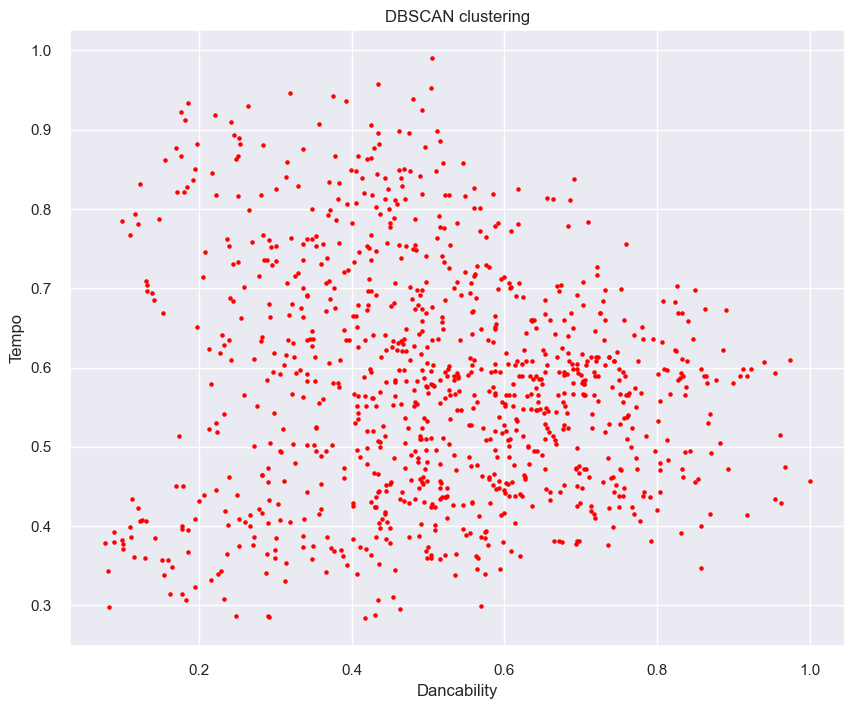

In [300]:
# Plot the clusters
plt.figure(figsize=(10, 8))
# plt.scatter(X[:, 0], X[:,1], s = 1, c = labels, cmap= "plasma") 
# plotting the clusters
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], s = 5, c = 'red', label = 'Cluster 1')
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], s = 5, c = 'blue', label = 'Cluster 2')
plt.scatter(X[Y == 2, 0], X[Y == 2, 1], s = 5, c = 'green', label = 'Cluster 3')
plt.scatter(X[Y == 3, 0], X[Y == 3, 1], s = 5, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[Y == 4, 0], X[Y == 4, 1], s = 5, c = 'magenta', label = 'Cluster 5')
plt.scatter(X[Y == 5, 0], X[Y == 5, 1], s = 5, c = 'orange', label = 'Cluster 6')
plt.scatter(X[Y == 6, 0], X[Y == 6, 1], s = 5, c = 'black', label = 'Cluster 7')
plt.scatter(X[Y == 7, 0], X[Y == 7, 1], s = 5, c = 'yellow', label = 'Cluster 8')
plt.scatter(X[Y == 8, 0], X[Y == 8, 1], s = 5, c = 'pink', label = 'Cluster 9')
plt.scatter(X[Y == 9, 0], X[Y == 9, 1], s = 5, c = 'brown', label = 'Cluster 10')

plt.title("DBSCAN clustering") # title of the plot
plt.xlabel("Dancability") # X-axis label
plt.ylabel("Tempo") # Y-axis label
plt.show() # showing the plot

Davies Bouldin 

In [301]:
davies_bouldin_score(X, labels)

2.5158587506114367

Silhouette

In [302]:
silhouette_score(X, labels)


0.35919119467596583